**Problem Statement:**

The grocery store is struggling with price fluctuations and shelf-life management of perishable goods. Predicting price changes and estimating shelf life accurately is crucial to optimizing inventory and reducing waste. Currently, the shop lacks a data-driven approach to understanding how factors like storage conditions, quality, and time in inventory affect product pricing and longevity.

To address this, a machine learning-based solution is being developed to analyze historical grocery data and predict:

Future price trends based on storage conditions and product attributes.

Shelf life estimation to improve stock management and reduce spoilage.

This solution aims to enhance inventory decision-making, minimize losses, and increase profitability through predictive analytics.

# 📌 **Mount Google Drive and Set Up the Project Path**
# This section ensures that the dataset is accessible from Google Drive.

In [27]:
# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from ipywidgets import widgets
from IPython.display import display

# Mount Google Drive
drive.mount('/content/drive')

# Set project directory
project_path = "/content/drive/My Drive/grocery_store_project"
os.makedirs(project_path, exist_ok=True)
%cd {project_path}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/grocery_store_project


# 📌 **Load Dataset**
# Reads the grocery dataset containing information about products and their prices.

In [28]:
# Cell 2: Load Dataset
data_path = os.path.join(project_path, 'vegetables_fruits_dataset.csv')
df = pd.read_csv(data_path)

print("Dataset Loaded Successfully!")

Dataset Loaded Successfully!


# 📌 **Data Visualization**
# Generates visualizations for price distribution and correlations between variables.

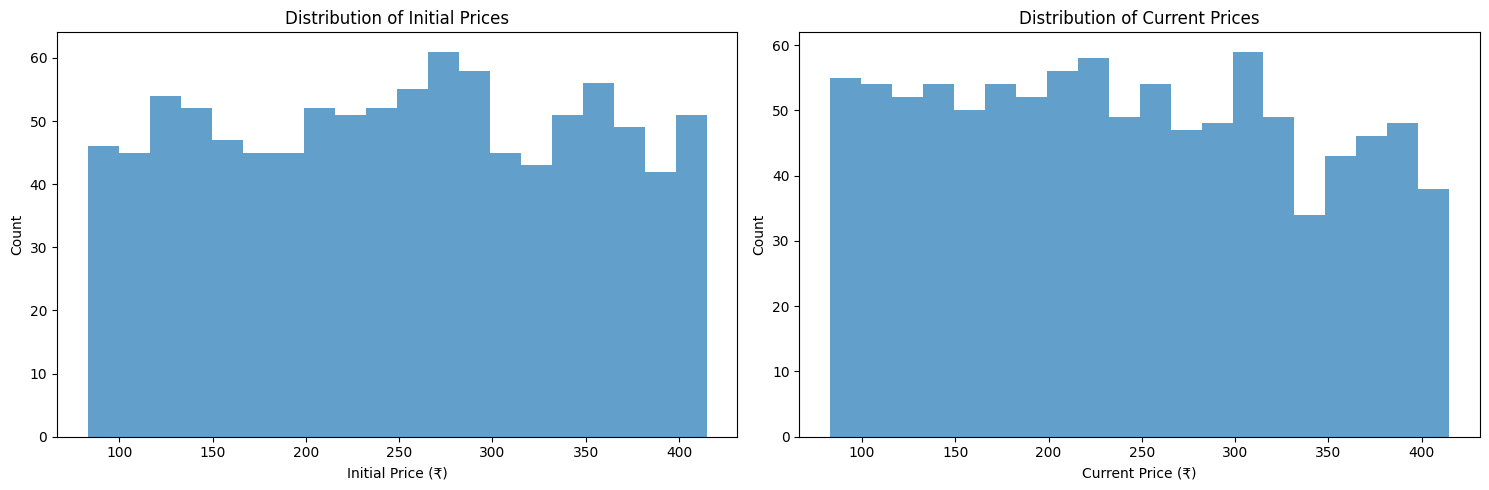

In [29]:
# Cell 3: Price Distribution Analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df['initial_price'], bins=20, alpha=0.7)
plt.title('Distribution of Initial Prices')
plt.xlabel('Initial Price (₹)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(df['current_price'], bins=20, alpha=0.7)
plt.title('Distribution of Current Prices')
plt.xlabel('Current Price (₹)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

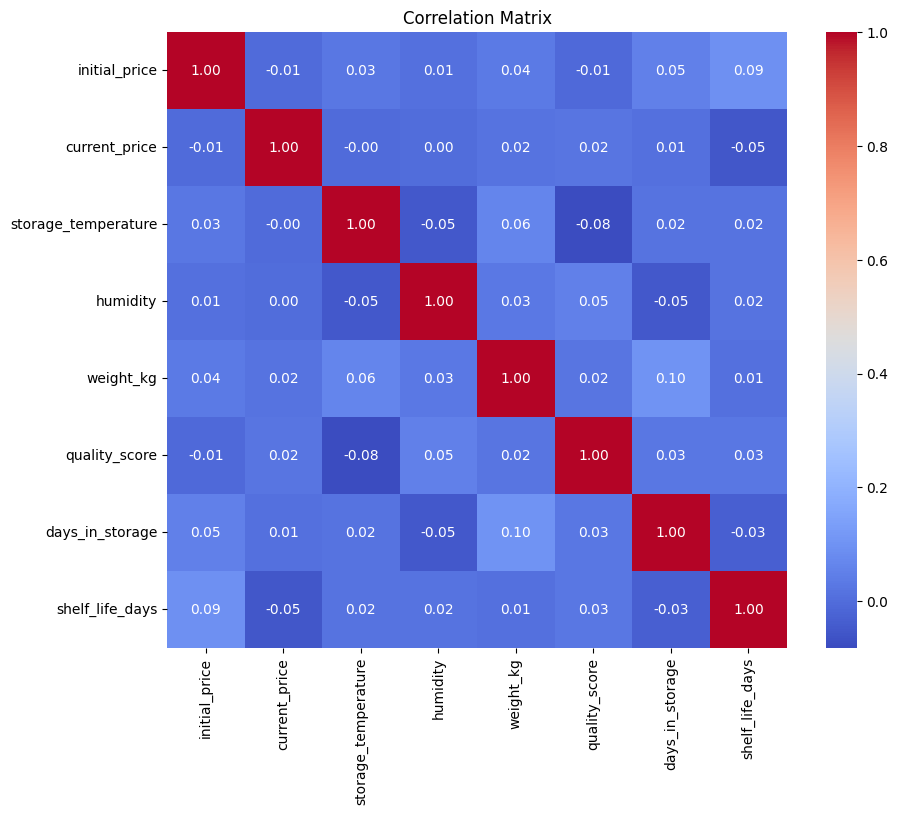

In [30]:
# Cell 4: Correlation Heatmap
numeric_cols = ['initial_price', 'current_price', 'storage_temperature', 'humidity', 'weight_kg', 'quality_score', 'days_in_storage', 'shelf_life_days']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# 📌 **Machine Learning Model Training**
# Uses Random Forest Regression to predict price changes and shelf life.

In [31]:
# Cell 5: Model Training
class GroceryPredictor:
    def __init__(self):
        self.price_model = None
        self.shelf_life_model = None
        self.scaler = StandardScaler()

    def load_data(self, file_path):
        df = pd.read_csv(file_path)
        df['arrival_date'] = pd.to_datetime(df['arrival_date'])
        df['arrival_date'] = (df['arrival_date'] - pd.Timestamp('1970-01-01')).dt.days

        features = ['arrival_date', 'initial_price', 'storage_temperature', 'humidity', 'weight_kg', 'quality_score', 'days_in_storage', 'is_organic']
        return df[features], df['current_price'], df['shelf_life_days']

    def train_models(self, data_path):
        print("\nTraining Models...")
        X, y_price, y_shelf_life = self.load_data(data_path)
        X_train, X_test, y_price_train, y_price_test, y_shelf_train, y_shelf_test = train_test_split(X, y_price, y_shelf_life, test_size=0.2, random_state=42)

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.price_model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.price_model.fit(X_train_scaled, y_price_train)

        self.shelf_life_model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.shelf_life_model.fit(X_train_scaled, y_shelf_train)

        print("Price Model R2 Score:", r2_score(y_price_test, self.price_model.predict(X_test_scaled)))
        print("Shelf Life Model R2 Score:", r2_score(y_shelf_test, self.shelf_life_model.predict(X_test_scaled)))


In [32]:
# Cell 6: Train Models
predictor = GroceryPredictor()
predictor.train_models(data_path)


Training Models...
Price Model R2 Score: -0.045700548979782374
Shelf Life Model R2 Score: -0.05196985958322142


# 📌 **Create an Interactive Prediction Interface**
# Allows users to input product attributes and get predictions for price and shelf life.

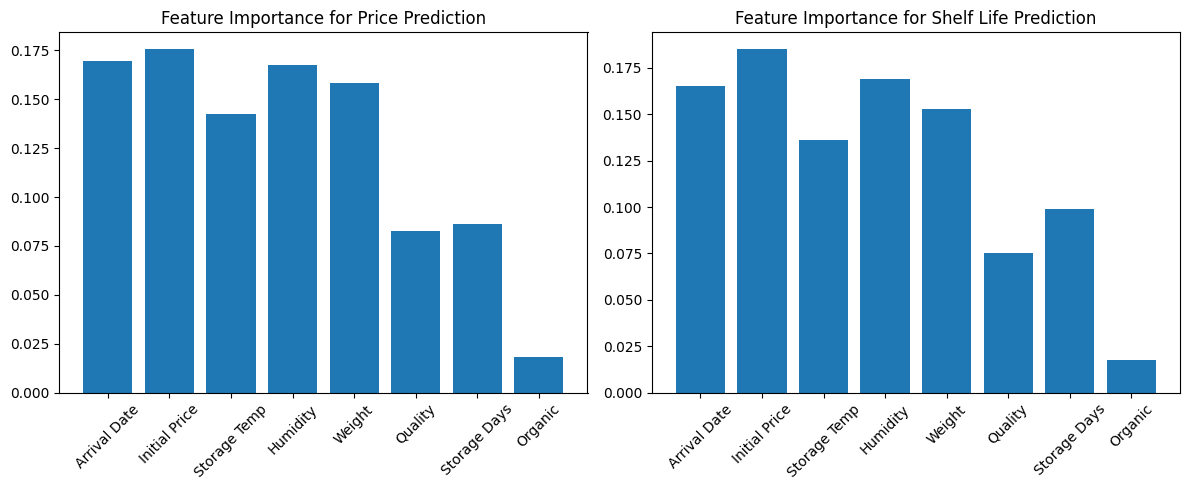

In [33]:
# Cell 7: Feature Importance Visualization
features = ['Arrival Date', 'Initial Price', 'Storage Temp', 'Humidity', 'Weight', 'Quality', 'Storage Days', 'Organic']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(features, predictor.price_model.feature_importances_)
plt.title('Feature Importance for Price Prediction')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(features, predictor.shelf_life_model.feature_importances_)
plt.title('Feature Importance for Shelf Life Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Cell 8: Prediction Interface
def create_prediction_interface():
    print("\nCreating Prediction Interface...")
    initial_price = widgets.FloatText(description='Initial Price (₹):', value=2.0)
    storage_temp = widgets.FloatText(description='Storage Temp (°C):', value=4.0)
    humidity = widgets.FloatText(description='Humidity (%):', value=60.0)
    weight = widgets.FloatText(description='Weight (kg):', value=0.5)
    quality = widgets.FloatSlider(min=1, max=10, description='Quality:', value=7)
    days_storage = widgets.IntText(description='Days in Storage:', value=1)
    is_organic = widgets.Checkbox(description='Is Organic')
    predict_button = widgets.Button(description='Predict')
    output = widgets.Output()

    def on_predict_button_clicked(b):
        with output:
            output.clear_output()
            features = np.array([[(datetime.now() - pd.Timestamp('1970-01-01')).days, initial_price.value, storage_temp.value, humidity.value, weight.value, quality.value, days_storage.value, int(is_organic.value)]])
            features_scaled = predictor.scaler.transform(features)
            price = predictor.price_model.predict(features_scaled)[0]
            shelf_life = predictor.shelf_life_model.predict(features_scaled)[0]
            print(f"Predicted Price: ₹{price:.2f}")
            print(f"Predicted Shelf Life: {shelf_life:.1f} days")

    predict_button.on_click(on_predict_button_clicked)
    display(initial_price, storage_temp, humidity, weight, quality, days_storage, is_organic, predict_button, output)


In [35]:
# Cell 9: Run Prediction Interface
create_prediction_interface()


Creating Prediction Interface...


FloatText(value=2.0, description='Initial Price (₹):')

FloatText(value=4.0, description='Storage Temp (°C):')

FloatText(value=60.0, description='Humidity (%):')

FloatText(value=0.5, description='Weight (kg):')

FloatSlider(value=7.0, description='Quality:', max=10.0, min=1.0)

IntText(value=1, description='Days in Storage:')

Checkbox(value=False, description='Is Organic')

Button(description='Predict', style=ButtonStyle())

Output()